W# Homework 6

## Modeling thermal effects in the battery Single Particle Model

### Suggested due date: before midnight on Wednesday, December 9.

For this assignment we are going to model the evolution of the temperature in our battery single particle model.  Our model will include the following phenomena:

- Ohmic (Joule) heating due to electronic current in cathode and anode solid phases
- Ohmic (Joule) heating due to ionic current in the electrolyte phase in the anode, cathode, and separator pores.
- Heating due to interface reactions in the anode and cathode (chemical and electric energy components)
- Conduction heat transfer between different components (anode, separator, cathode)
- Convection heat transfer at the battery boundaries (anode surface and cathode surface)
- Radiation heat transfer at the battery boundaries (anode surface and cathode surface)


The needed parameters have all been added to the battery `input` file, and calculated as needed in the battery `init` file.  I suggest you read through these files to understand what these parameters represent.

I have also done many of the preliminary calculations needed for your thermal model, in the `function` file.  What is left for you to do is to calculate the volumetric heat generation term, `Q_XX`, where `XX` represents a given phenomena from the bulleted list above.

For the single particle model, we have only three nodes (anode, electrolyte separator, and cathode).  For our thermal model, the, we track a single temperature for each.

You can go ahead and code all the `Q_XX` terms at one time, but we will add these phenomena one at a time, using a series of 'flags' that are set to either 0 or 1.  We will simulate a single charge curve at varying rates, to see the relative impact of each phenomenon, and how it depends on the charging rate of the battery.

Note that there is some internal inconsistency, here: Many of the phenomena above (such as ohmic losses in the electrodes and electrolyte) are not actually incorporated into our battery model (the electrolyte potential, for example, is assumed to be constant at zero).  We also have not incorporated any balance equations for species. For this reason, we will not pay any attention to the cell voltage.

Also, note that _many_ of these properties will vary as a funciton of temperature, in ways that would most certainly impact our temperature evolution.  Our work here will serve as a suitable first approximation, though.

Lastly, FWIW, the included python files demonstrate some new tricks that you might find useful for your project, such as passing 'keywords' when you call a function, which are then passed to the `main` model function.

# Working with this notebook.

1. You should not touch any of the code in the workbook.  All of your coding will be added to the `battery_spm` python files.
2. In this notebook, the only changes you will make are discussing the results.  Each discussion block is highlighted by <font color="red">**red, bold text**</font>.  **Please leave these markers in (do not delete them)**, so that I can easily find your discussion entries.
3. In your discussions, please refer to specific model equations or parameters from the battery spm code, to explain the trends that you see.  
4. If you are making changes to your python code which you feel are not being reflected in these results, you might was to click `Kernel->Restart` (or `Kernel->Restart and Clear Output` or `Kernel->Restart and Run All`) up at the top of this page.  I have added a bunch of code below (all the `importlib.reload` stuff, below), such that you shouldn't need to.  But just in case...
5. Finally, push all of your code (python files and this notebook) to your github repo and make a pull request, to submit.

Good luck!

# Battery cycling function

This function will call our battery model three times, for three different cycling rates (0.1 C, 1.0 C, and 10.0 C).  It will then plot the temperature profiles for the anode, separator, and cathode, as a function of time. Note that a charge at 0.1 C takes 100 times longer than one at 10 C.

In [44]:
# This will make it so that our notebook recognizes and reloads changes we have made in our python files:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import importlib
def plot_function(ax,sol,ptr,rate):
       
    from matplotlib import pyplot as plt
    ax.plot(sol.t, sol.y[ptr.T_an,:]-273)
    ax.plot(sol.t, sol.y[ptr.T_elyte,:]-273)
    ax.plot(sol.t, sol.y[ptr.T_ca,:]-273)
        
    ax.set_title('C-rate = '+str(rate)+'C',fontsize=14)
    return ax
    

def cycle_function(flags):
    from matplotlib import pyplot as plt

    import battery_spm_init
    importlib.reload(battery_spm_init)
    from battery_spm_init import ptr
    
    import battery_spm_model
    importlib.reload(battery_spm_model)
    from battery_spm_model import cycle
    
    solution_01 = cycle(C_rate = 0.1, thermal_flags = flags)
    
    
    import battery_spm_init
    importlib.reload(battery_spm_init)
    from battery_spm_init import ptr
    
    import battery_spm_model
    importlib.reload(battery_spm_model)
    from battery_spm_model import cycle
    
    solution_1 = cycle(C_rate = 1.1, thermal_flags = flags)


    import battery_spm_init
    importlib.reload(battery_spm_init)
    from battery_spm_init import ptr
    
    import battery_spm_model
    importlib.reload(battery_spm_model)
    from battery_spm_model import cycle
    
    solution_10 = cycle(C_rate = 10, thermal_flags = flags)
    
    fig, axs = plt.subplots(1, 3, constrained_layout=False)
    fig.set_size_inches((12,3))
    axs[0] = plot_function(axs[0],solution_01,ptr,0.1)
    axs[1] = plot_function(axs[1],solution_1,ptr,1.0)
    axs[2] = plot_function(axs[2],solution_10,ptr,10)
    axs[1].legend(['Anode temperature','Separator temperature', 'Cathode temperature'],frameon=False)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    axs[0].set_ylabel('T (C)',fontsize=14)
    
    plt.xlabel('Time (s)', fontsize=16)


# Okay, here is the actual assignment:
## Part I: Baseline: No thermal effects
We set all 'flag' values to zero, which sets all heat sources to zero.  Even if you have not added any code to the model, this part should run fine and give a constant T profile:

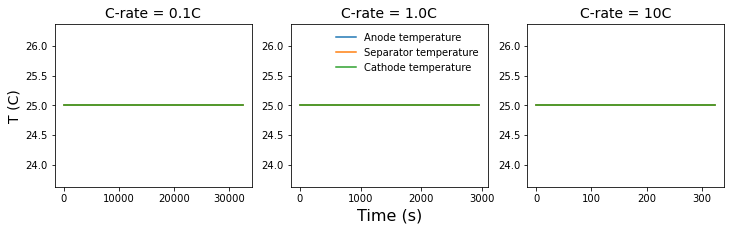

In [46]:
class thermal_flags:
    rxn = 0 # heat due to surface reactions
    ohm_el = 0 # ohmic/Joule heating from electron conduction
    ohm_io = 0 # ohmic/Joule heating from ion conduction
    cond = 0 # Heat transfer via thermal conduciton
    conv = 0 # Heat transfer via external convection
    rad = 0 # Heat tranfer via external radiation
    
cycle_function(thermal_flags)

## Part II: Heat released by reactions

The code already calculates $\dot{s}_{k,{\rm int}}$, the molar production of species due to interfacial reactions, and $e_k = h_k + z_kF\phi_k$, the energy of each species (note that an electron is a specie!).  Fill in the equation `Q_rxn`, the volumetric heating rate (W/m$^3$) due to these reactions.

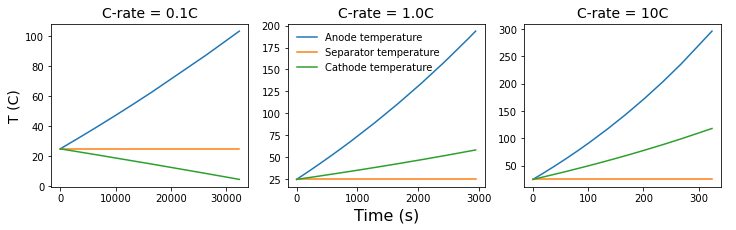

In [47]:
thermal_flags.rxn = 1 # This will stay at 1, from here on out.
cycle_function(thermal_flags)

### Discussion
You should see a dramatic change, relative to Part I.  Discuss these results.  Are they believable?  Would this be a good result for the battery?  Why do we see these trends, and what do you predict will happen as we add in more thermal effects

<font color='red'>[Directionally, these changes make sense, with the magnitude of the temperature increase being significantly greater for a higher C-rate. We are only looking at heat generation without considering ways that the heat could be dissipated (via conduction, convection, radiation with outside environment), so it makes sense that the anode temperature increases. As there is no reaction in the separator, we would expect its temperature to stay constant. For a real battery, this would be bad, as it could quickly lead to thermal runaway if there is no thermal management, keeping all the heat of reaction inside the battery.]</font>
    
You should also see the temperature trend for the cathode switch, when going from 0.1C to 1.0C


<font color='red'>[**Initially, at a low C-rate, the cathode temperature decreases over time due to the endothermic reaction occurring in the cathode. However, as the C-rate increases, Faradaic heat generation from the surface reactions produces more heat than the endothermic reaction absorbs, leading to a higher temperature in the cathode at higher C-rates**]</font>

## Part III: Ohmic/Joule Heating

### a. Electron conduction

Add in the equation for the volumetric heating rate due to electron conduction, `Q_ohm_el`.  The code already has calculated `pars.R_el_electrode` for each electrode phase (`pars.R_el_an` and `pars.R_el_ca`), which are the _resistivities_ $\rho_{\rm el}$ (units: $\Omega-m$).

Because we have a single volume for each electrode, we know _a priori_ the electronic current in each electrode (hint: no calculations are needed, for both $i_{\rm elec}$ in the electrodes and $i_{\rm io}$ in the electrolyte phase).

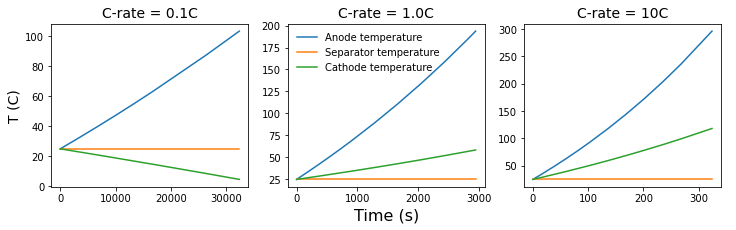

In [48]:
thermal_flags.ohm_el = 1
cycle_function(thermal_flags)

### Discussion:

Do you see any significant changes, relative to Part II?  You should not.  Why?  What does this say about electronic conduction, and which input parameter determined this?

<font color='red'>[No, there are no significant changes. This is because the magnitude of ohmic heat generation from electric current is small relative to the heat generated from the reaction. This is likely due to relatively low internal resistance within the battery, which keeps this form of heat generation to a minimum.]</font>

### b. Ion conduction

Repeat part 1, but for Joule heating due to ion conduction, `Q_ohm_io`.  Note that there is ion conduction in the two electrodes _and_ in the electrolyte separator.

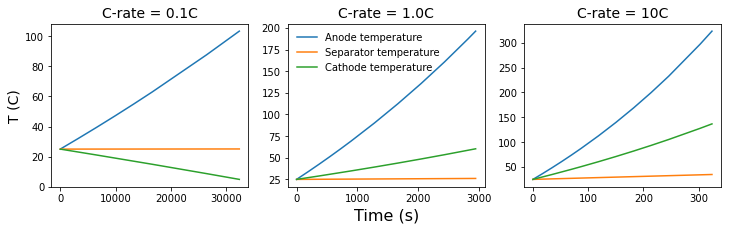

In [49]:
thermal_flags.ohm_io = 1
cycle_function(thermal_flags)

### Discussion:

Do you see any significant changes, relative to Parts II and IIa?  Look closely - there should be some minor changes.  Why?  What does this say about ion conduction, and which input parameter determined this?

Is there a larger impact for some C-rates, compared to others?  Why?

<font color='red'>[**There is not a major change, but it appears that at higher C-rates, the separator temperature starts to increase. This is caused by resistance to the ionic conduction that leads to heat generation. This effect is amplified at higher C-rate since the heat generated from ionic current increases exponentially as current increases. This effect is affected by the ionic resistance, which is a function of the porosity of the separator.**]</font>

## Part IV: Thermal conduction

Now implement thermal conductivity equations.  This is done in two steps, in the code:

1. Calculate the conduction heat transfer fluxes `Q_cond_an` and `Q_cond_ca`:
- From the anode to the separator: $\dot{Q}^{\prime\prime}_{\rm cond,an} = -\lambda_avg\nabla T$ (W/m$^2$)
- From the anode to the separator: $\dot{Q}^{\prime\prime}_{\rm cond,ca} = -\lambda_avg\nabla T$ (W/m$^2$)

For both calculations, the volume-weighted average thermal conductivity `lambda` at the relevant electrode/separator interface and the distance between the two volume centers `dyInv` are already calculated for you. 

2. Once the relevant heat fluxes are calculated, calculate the relevant volumetric heat generation terms due to conduction `Q_cond` for the anode, separator, and cathode.

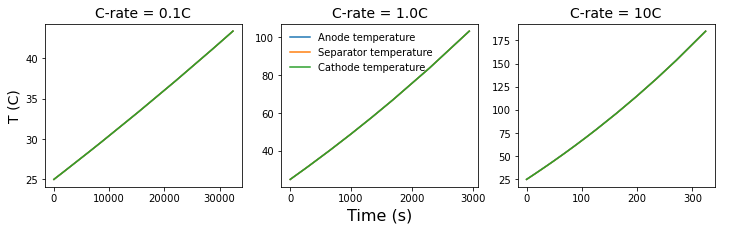

In [50]:
thermal_flags.cond = 1
cycle_function(thermal_flags)

### Discussion:

There should once again be a significant change, relative to Part III. You should see that the anode, separator, and cathode temperatures have all collapsed onto one another. Why is that?  What properties in our inputs lead to this behavior?

What happens to the overall magnitude of the temperatures, relative to part III?  Does this make sense, based on our cell geometry?  What does it say about the "thermal mass" of each component?

Do you thnk these results are accurate?  Why or why not?  Would _this_ be a good temperature profile, for a battery (i.e. would we want our battery to experience these temperatures?)

<font color='red'>[**The major change that has occurred to cause the temperatures to converge is that there is now heat exchange between the components of the battery in the form of conduction, leading the battery to have a uniform temperature. Inputs that affect this are the thermal conductivity for the electrodes and separator and the thickness of each component. A greater thermal conductivity leads to the battery temperature becoming uniform more quickly, and smaller thicknesses will also lead to quicker establishment of thermal equilibrium within the battery.
    The maximum temperature of the battery is significantly lower than in part 3, caused by the electrolyte and cathode absorbing heat from the anode. Given that the thickness of the cathode is equal to the thickness of the anode, it makes sense that they would have a similar thermal mass. **]</font>
    
<font color='red'>[**These results are reasonable, though they do not include convection or radiation, which are important modes of heat transfer to keep the battery temperature down. These temperatures would still be problematic for a battery, particularly at higher C-rates. **]</font>

## Part V: Radiation heat transfer

Now implement radiation heat transfer at the battery surface (anode and cathode bondaries).
\begin{equation}
    \dot{Q}^{\prime\prime}_{\rm rad} = \sigma\epsilon\left(T^4_{\rm amb} - T^4_{\rm surf}\right)\frac{A}{V}
\end{equation}
The model code has already defined `sigma`, the Stefan-Boltzmann constant, plus `pars.emmissivity`, the surface emmissivity ($\epsilon$), the ambient temperature `pars.T_amb`, and `pars.A_ext`, the surface area per unit volume for both electrodes, (i.e. $\frac{A}{V}$ in the equation above. Tthe same value is used for both electrodes).

Calculate `Q_rad`, the total heat transferred to each component per unit volume.


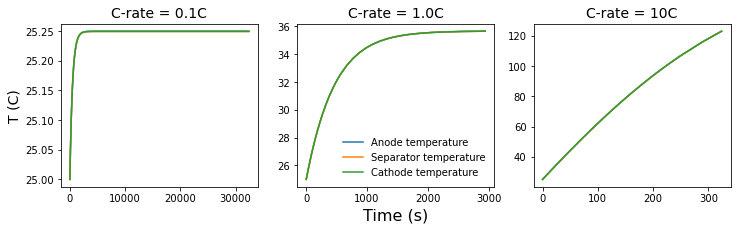

In [51]:
thermal_flags.rad = 1
cycle_function(thermal_flags)

### Discussion 

<font color='red'>[At a C-rate of 0.1C, the battery reaches steady-state at a temperature of ~25.25 Celsius. For a C-rate of 1.0C, the steady-state temperature is higher, at almost 36 Celsius, and at 10C, the battery does not reach steady-state before the charge is depleted. This makes sense, since steady state is achieved when the heat being generated within the battery is equal to the rate at which heat is being dissipated through conduction, convection, and radiation. For a lower C-rate, heat is being generated much more slowly, so it can be dissipated easily, even if there is not a major temperature difference to drive heat transfer. Conversely, with a higher C-rate, the pace of heat generation outpaces the rate of heat dissipation, so the temperature continues to increase up until the charge is depleted. The steady state temperature is a function of the rate of heat generation within the battery with higher rates of heat generation leading to higher steady state temperatures.]</font>

What do you notice?  Is this believable?  Why do some C-rates reach a steady-state value, and some do not?

For those that do reach a steady-state temperature, what determines the steady state value?  What processes are being balanced, at steady state?

## Part VI: Convection heat transfer.

Now we'll turn radiation back off, and instead model convective heat transfer at the boundary.  Similar to above, calculate a `Q_rad` value: 
\begin{equation}
    \dot{Q}^{\prime\prime}_{\rm conv} = h_{\rm conv}\left(T_{\rm amb} - T_{\rm surf}\right)\frac{A}{V}
\end{equation}
where `pars.h_conv` is already defined for you (same value for anode and cathode).

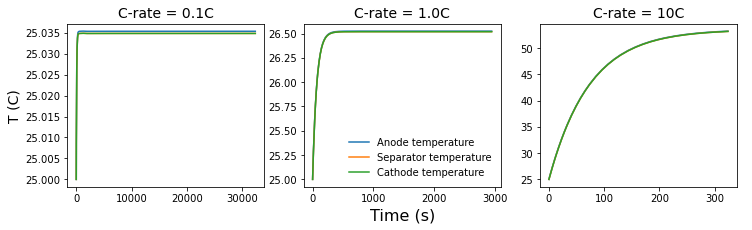

In [52]:
thermal_flags.rad = 0
thermal_flags.conv = 1
cycle_function(thermal_flags)

### Discussion 

<font color='red'>[Considering only conduction and convection, the battery reaches steady state temperature more quickly than with conduction and radiation. This suggests that convection has a greater influence on the total rate of heat transfer than radiation for the given inputs. ]</font>

What do you notice?  What does this say about the relative influence of convection vs. radiation heat transfer, for the given input parameters?

## Part VII: Putting it all together

Okay, finally, incorporate all thermal effects:

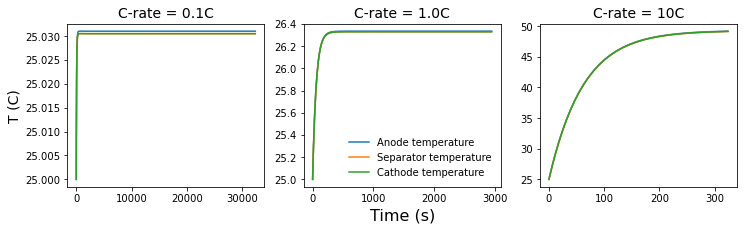

In [53]:
thermal_flags.rad = 1
cycle_function(thermal_flags)

### Discussion

Now that we have all thermal effects incorporated, answer a few final questions:

1.  Would _this_ be a good temperature for our battery?

<font color='red'>[This would be a good temperature for the battery, though there may still be a concern of overheating leading to thermal runaway for the high C-rate case, so it would be important to have proper thermal management for applications that require high power relative to the battery energy capacity.]</font>

2.  If we incorporated temperature dependent parameters, how do you think our results would change?  Be specific: which parameters would change, and how would this impact our various thermal terms (i.e. conduction, ohmic, etc...)

Note: For some parameters (ahem, _species thermo_), we don't really have enough info to say exactly how the results would change.  Saying "I don't know, but it would depend on X, Y, Z" is perfectly fine.

<font color='red'>[The net effect of incorporating temperature dependent parameters on these results depends on how strong the temperature dependence is for those parameters. For example, one could incorporate graphite having a greater thermal conductivity as temperature would increase, which would increase the rate of conduction, increasing the overall rate of heat transfer and leading to lower steady state battery temperatures. On the other hand, one could incorporate decreasing electrical conductivity as temperature increases, which would increase the internal resistance of the battery, causing an increase in ohmic heat generation, which would lead to a higher steady state temperature for the battery. ]</font>

3. Discuss the influence of C-rate on our battery's thermal response.  Is the relationship between C-rate and max temperature linear? (hint: it is not) Why do you think this is?  What about the dynamic response?  With increasing C-rate, we see that the battery takes _a greater fraction of the total charge time_ to reach steady state. Why is that?  Is the dynamic response actually slower at higher C-rate, or is there something else goign on?

<font color='red'>[As the C-rate increases, the max temperature of the battery also increases. Presumably, this relationship is exponential in nature, due to the exponential increases in the rate of heat generation (ohmic and Faradaic) as the current increases. The increase in the fraction of total charge time required to reach steady state as C-rate increases is due to two main effects: (1) higher heat generation causing the steady-state temperature to increase, requiring more heat to reach; and (2) shorter discharge times. In terms of the number of seconds required to reach steady-state, the results are actually fairly consistent across the C-rates. ]</font>

# Thanks for a really great semester.  You've all worked incredibly hard, under difficult circumstances, and I've been impressed by all that you've learned, and sincerely enjoyed getting to spend Tuesdays and Thursdays with you!

## Please feel free to stay in touch, after the semester is over.  I'll leave the Slack workspace open, so long as people are using it.

## If there is any way I can be of use/assistance, either during your time at Mines or beyond, don't hesitate to reach out!  Slack is best, so long as the workspace remains open.

# <font color='red'>{Thank you for everything! This course inspired me to register for a data science course for next spring so I can become at least somewhat proficient with Python. This class was incredibly challenging, but I learned a ton, so thank you!]</font>